Tutorial de detección de anomalías en registros de latidos del corazón con Autoencoder LSTM+CNN vs. Bosque de aislamiento<br>
https://www.youtube.com/watch?v=C041VXuHafI&list=PLBYdyi7-DjV33GOnmCbtR9mLOEQr9txnz&index=2

In [ ]:
pip install keras

#Importar librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.ensemble import IsolationForest

from keras.models import Model, Sequential
from keras.layers import Dense, LSTM, GRU, Dropout, Input, Conv1D, MaxPooling1D, Flatten, RepeatVector, TimeDistributed

#EDA
##Datos normales

In [3]:
dato_normal = pd.read_csv('ptbdb_normal.csv')
dato_normal.head()

,1.000000000000000000e+00,9.003241658210754395e-01,3.585899472236633301e-01,5.145867168903350830e-02,4.659643396735191345e-02,1.268233358860015869e-01,1.333063244819641113e-01,1.191247999668121338e-01,1.106158867478370667e-01,1.130470037460327148e-01,...,0.000000000000000000e+00.56,0.000000000000000000e+00.57,0.000000000000000000e+00.58,0.000000000000000000e+00.59,0.000000000000000000e+00.60,0.000000000000000000e+00.61,0.000000000000000000e+00.62,0.000000000000000000e+00.63,0.000000000000000000e+00.64,0.000000000000000000e+00.65
0,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.948983,0.505265,0.004176,0.022513,0.059550,0.107298,0.110385,0.111293,0.116558,0.118192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
dato_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4045 entries, 0 to 4044
Columns: 188 entries, 1.000000000000000000e+00 to 0.000000000000000000e+00.65
dtypes: float64(188)
memory usage: 5.8 MB


In [5]:
dato_normal.describe()

,1.000000000000000000e+00,9.003241658210754395e-01,3.585899472236633301e-01,5.145867168903350830e-02,4.659643396735191345e-02,1.268233358860015869e-01,1.333063244819641113e-01,1.191247999668121338e-01,1.106158867478370667e-01,1.130470037460327148e-01,...,0.000000000000000000e+00.56,0.000000000000000000e+00.57,0.000000000000000000e+00.58,0.000000000000000000e+00.59,0.000000000000000000e+00.60,0.000000000000000000e+00.61,0.000000000000000000e+00.62,0.000000000000000000e+00.63,0.000000000000000000e+00.64,0.000000000000000000e+00.65
count,4045.000000,4045.000000,4045.000000,4045.000000,4045.000000,4045.000000,4045.000000,4045.000000,4045.000000,4045.000000,...,4045.000000,4045.000000,4045.000000,4045.000000,4045.000000,4045.000000,4045.000000,4045.000000,4045.0,4045.0
mean,0.979665,0.711439,0.311665,0.119592,0.088618,0.130844,0.159659,0.165619,0.168020,0.170797,...,0.001540,0.001332,0.001304,0.001220,0.000991,0.000895,0.000454,0.000474,0.0,0.0
std,0.029063,0.186376,0.183478,0.110466,0.075767,0.081114,0.090141,0.096103,0.102515,0.106199,...,0.018666,0.016236,0.016670,0.016660,0.015206,0.015313,0.010835,0.011203,0.0,0.0
min,0.782178,0.121784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,0.964454,0.580160,0.164109,0.028717,0.027734,0.070772,0.094654,0.098848,0.095575,0.094969,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,1.000000,0.726231,0.303182,0.092677,0.079580,0.121076,0.134367,0.142857,0.143004,0.145076,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
75%,1.000000,0.863610,0.436192,0.187659,0.134871,0.183774,0.216205,0.217932,0.220616,0.223067,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
max,1.000000,1.000000,0.985955,0.910798,0.846591,0.770205,0.754524,0.749095,0.729192,0.700844,...,0.415879,0.361283,0.383522,0.407025,0.446281,0.483471,0.371502,0.376668,0.0,0.0


In [6]:
dato_normal.describe().T[["min","max"]]

,min,max
1.000000000000000000e+00,0.782178,1.000000
9.003241658210754395e-01,0.121784,1.000000
3.585899472236633301e-01,0.000000,0.985955
5.145867168903350830e-02,0.000000,0.910798
4.659643396735191345e-02,0.000000,0.846591
...,...,...
0.000000000000000000e+00.61,0.000000,0.483471
0.000000000000000000e+00.62,0.000000,0.371502
0.000000000000000000e+00.63,0.000000,0.376668
0.000000000000000000e+00.64,0.000000,0.000000


##Datos anormales

In [7]:
dato_anormal = pd.read_csv('ptbdb_abnormal.csv')
dato_anormal.head()

,9.322328567504882812e-01,8.696785569190979004e-01,8.861859440803527832e-01,9.296264052391052246e-01,9.087749719619750977e-01,9.339704513549804688e-01,8.010425567626953125e-01,7.497828006744384766e-01,6.872285008430480957e-01,6.350998878479003906e-01,...,0.000000000000000000e+00.117,0.000000000000000000e+00.118,0.000000000000000000e+00.119,0.000000000000000000e+00.120,0.000000000000000000e+00.121,0.000000000000000000e+00.122,0.000000000000000000e+00.123,0.000000000000000000e+00.124,0.000000000000000000e+00.125,1.000000000000000000e+00.1
0,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.925265,0.433352,0.073620,0.079197,0.136643,0.182934,0.182934,0.182376,0.196877,0.203569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
dato_anormal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10505 entries, 0 to 10504
Columns: 188 entries, 9.322328567504882812e-01 to 1.000000000000000000e+00.1
dtypes: float64(188)
memory usage: 15.1 MB


In [9]:
dato_anormal.describe()

,9.322328567504882812e-01,8.696785569190979004e-01,8.861859440803527832e-01,9.296264052391052246e-01,9.087749719619750977e-01,9.339704513549804688e-01,8.010425567626953125e-01,7.497828006744384766e-01,6.872285008430480957e-01,6.350998878479003906e-01,...,0.000000000000000000e+00.117,0.000000000000000000e+00.118,0.000000000000000000e+00.119,0.000000000000000000e+00.120,0.000000000000000000e+00.121,0.000000000000000000e+00.122,0.000000000000000000e+00.123,0.000000000000000000e+00.124,0.000000000000000000e+00.125,1.000000000000000000e+00.1
count,10505.000000,10505.000000,10505.000000,10505.000000,10505.000000,10505.000000,10505.000000,10505.000000,10505.000000,10505.000000,...,10505.000000,10505.000000,10505.000000,10505.000000,10505.000000,10505.000000,10505.000000,10505.000000,10505.0,10505.0
mean,0.975472,0.725568,0.438264,0.290324,0.252834,0.249358,0.245615,0.247112,0.250161,0.252359,...,0.001055,0.001057,0.000744,0.000554,0.000533,0.000313,0.000070,0.000074,0.0,1.0
std,0.036353,0.199035,0.262676,0.270918,0.236929,0.211656,0.200095,0.194787,0.193122,0.192314,...,0.022313,0.022586,0.017558,0.013782,0.013554,0.010902,0.003754,0.004044,0.0,0.0
min,0.624227,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0
25%,0.957327,0.586560,0.236455,0.074056,0.088472,0.101419,0.097175,0.096330,0.098525,0.098015,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0
50%,1.000000,0.745576,0.404234,0.212766,0.173045,0.180902,0.182768,0.191774,0.197084,0.200908,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0
75%,1.000000,0.890045,0.620887,0.427714,0.343034,0.327502,0.328070,0.347676,0.359160,0.370047,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.985523,0.993213,0.997738,...,0.791899,0.773743,0.789804,0.628177,0.602033,0.644880,0.265025,0.279310,0.0,1.0


##Visualizar 1 vs. 1

In [10]:
muestra_normal = dato_normal.iloc[:,:-1].sample(1).values.flatten()
muestra_anormal = dato_anormal.iloc[:,:-1].sample(1).values.flatten()

In [11]:
muestra_normal

array([1.        , 0.38903224, 0.01612903, 0.05096774, 0.12451613,
       0.19032258, 0.22645161, 0.2167742 , 0.24129032, 0.22451612,
       0.23999999, 0.25612903, 0.23161291, 0.25419354, 0.25806451,
       0.25096774, 0.25483871, 0.27419356, 0.26193547, 0.29935485,
       0.27870968, 0.30903226, 0.33032259, 0.33032259, 0.37612903,
       0.38193548, 0.42580646, 0.45225805, 0.48129031, 0.50709677,
       0.51999998, 0.5212903 , 0.52064514, 0.5212903 , 0.45870969,
       0.43806452, 0.39419356, 0.36709678, 0.32258064, 0.31741935,
       0.29935485, 0.28709677, 0.28064516, 0.28516129, 0.27741936,
       0.28258064, 0.28645161, 0.28774193, 0.28838709, 0.29032257,
       0.28      , 0.28193548, 0.29612902, 0.29032257, 0.27161291,
       0.27419356, 0.28129032, 0.26838711, 0.27161291, 0.28258064,
       0.29354838, 0.27225807, 0.25290322, 0.25225806, 0.26709679,
       0.27225807, 0.27612904, 0.25032258, 0.24967742, 0.25806451,
       0.27161291, 0.25096774, 0.25741935, 0.29419354, 0.34193

In [12]:
muestra_normal

array([1.        , 0.38903224, 0.01612903, 0.05096774, 0.12451613,
       0.19032258, 0.22645161, 0.2167742 , 0.24129032, 0.22451612,
       0.23999999, 0.25612903, 0.23161291, 0.25419354, 0.25806451,
       0.25096774, 0.25483871, 0.27419356, 0.26193547, 0.29935485,
       0.27870968, 0.30903226, 0.33032259, 0.33032259, 0.37612903,
       0.38193548, 0.42580646, 0.45225805, 0.48129031, 0.50709677,
       0.51999998, 0.5212903 , 0.52064514, 0.5212903 , 0.45870969,
       0.43806452, 0.39419356, 0.36709678, 0.32258064, 0.31741935,
       0.29935485, 0.28709677, 0.28064516, 0.28516129, 0.27741936,
       0.28258064, 0.28645161, 0.28774193, 0.28838709, 0.29032257,
       0.28      , 0.28193548, 0.29612902, 0.29032257, 0.27161291,
       0.27419356, 0.28129032, 0.26838711, 0.27161291, 0.28258064,
       0.29354838, 0.27225807, 0.25290322, 0.25225806, 0.26709679,
       0.27225807, 0.27612904, 0.25032258, 0.24967742, 0.25806451,
       0.27161291, 0.25096774, 0.25741935, 0.29419354, 0.34193

In [13]:
muestra_normal = [m for m in muestra_normal if m > 0]
muestra_anormal = [m for m in muestra_anormal if m > 0]
muestra_normal

[1.0,
 0.389032244682312,
 0.016129031777381897,
 0.050967741757631295,
 0.12451612949371337,
 0.19032257795333865,
 0.22645160555839536,
 0.21677419543266296,
 0.2412903159856796,
 0.22451612353324887,
 0.239999994635582,
 0.25612902641296387,
 0.2316129058599472,
 0.2541935443878174,
 0.25806450843811035,
 0.25096774101257324,
 0.2548387050628662,
 0.27419355511665344,
 0.26193547248840326,
 0.29935485124588007,
 0.27870967984199524,
 0.3090322613716125,
 0.33032259345054626,
 0.33032259345054626,
 0.37612903118133534,
 0.3819354772567749,
 0.42580646276474,
 0.45225805044174194,
 0.4812903106212616,
 0.5070967674255371,
 0.5199999809265137,
 0.5212903022766113,
 0.5206451416015625,
 0.5212903022766113,
 0.4587096869945526,
 0.43806451559066767,
 0.39419355988502497,
 0.3670967817306519,
 0.32258063554763794,
 0.31741935014724726,
 0.29935485124588007,
 0.28709676861763,
 0.28064516186714167,
 0.2851612865924835,
 0.2774193584918976,
 0.2825806438922882,
 0.2864516079425812,
 0.28774

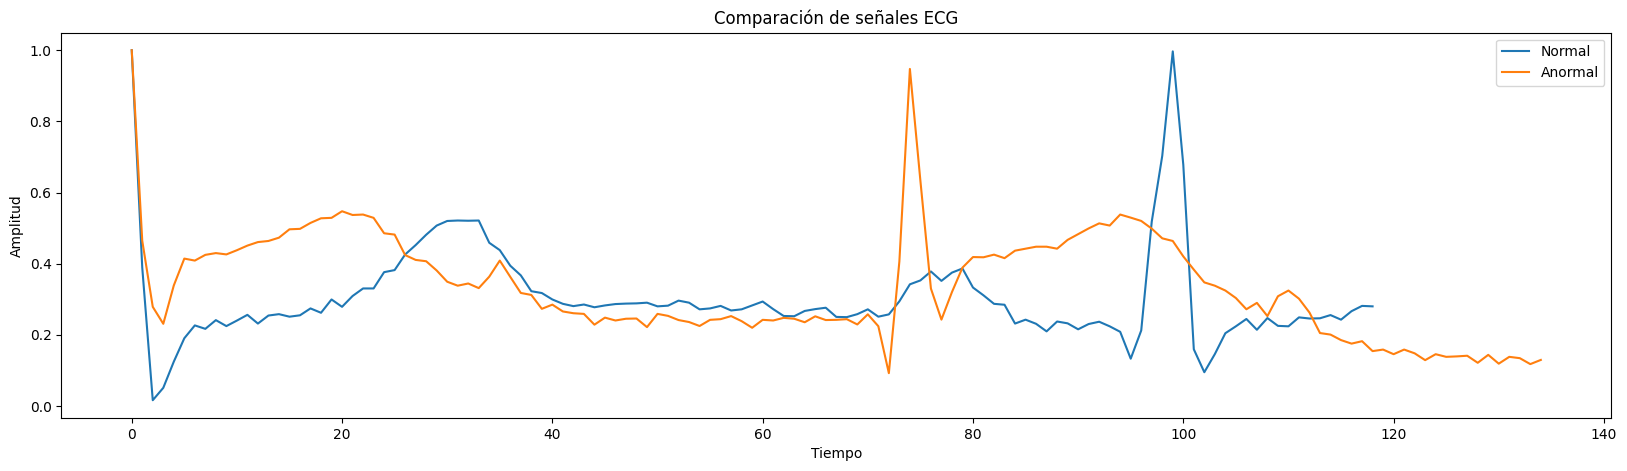

In [14]:
#Visualizar las priemras filas de muestras en el tiempo
plt.figure(figsize=(20,5))
plt.plot(muestra_normal, label='Normal')
plt.plot(muestra_anormal, label='Anormal')
plt.title('Comparación de señales ECG')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

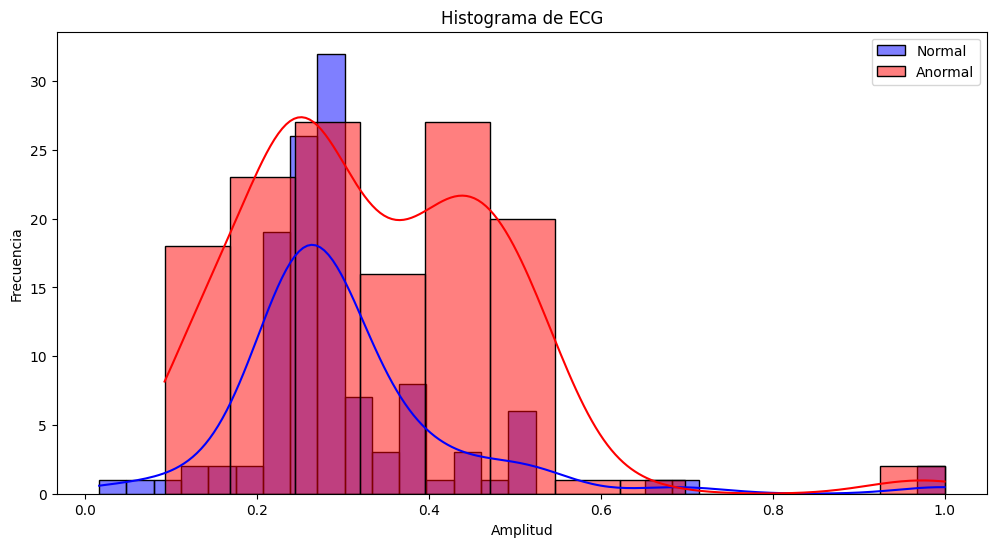

In [15]:
#Histogramas
plt.figure(figsize=(12, 6))
sns.histplot(muestra_normal,
             kde=True,
             color='blue',
             label='Normal')
sns.histplot(muestra_anormal,
             kde=True,
             color='red',
             label='Anormal')
plt.title('Histograma de ECG')
plt.xlabel('Amplitud')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

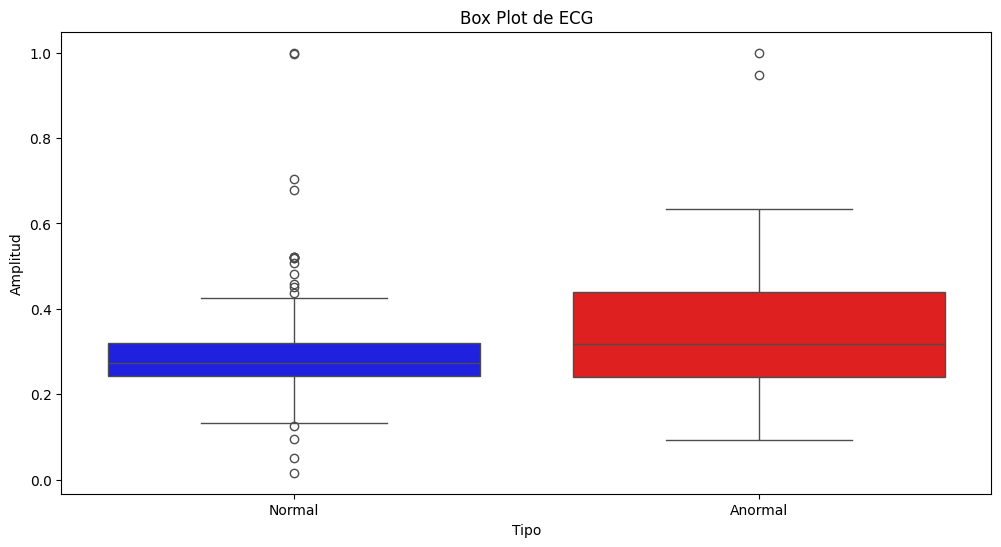

In [16]:
#Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=[muestra_normal, muestra_anormal],
            palette=['blue', 'red'])
plt.xticks([0, 1], ['Normal', 'Anormal'])
plt.title('Box Plot de ECG')
plt.xlabel('Tipo')
plt.ylabel('Amplitud')
plt.show()

## Descomposición

In [17]:
#La columna "Value" es un resumen de la señal ECG del registro
dato_normal['value'] = dato_normal.mean(axis=1)
dato_anormal['value'] = dato_anormal.mean(axis=1)

dato_normal['value'].describe()

,value
count,4045.000000
mean,0.157616
std,0.067575
min,0.039428
25%,0.106709
50%,0.144347
75%,0.181903
max,0.418110


In [18]:
dato_anormal['value'].describe()

,value
count,10505.000000
mean,0.184195
std,0.094326
min,0.048895
25%,0.110397
50%,0.164991
75%,0.233171
max,0.735861


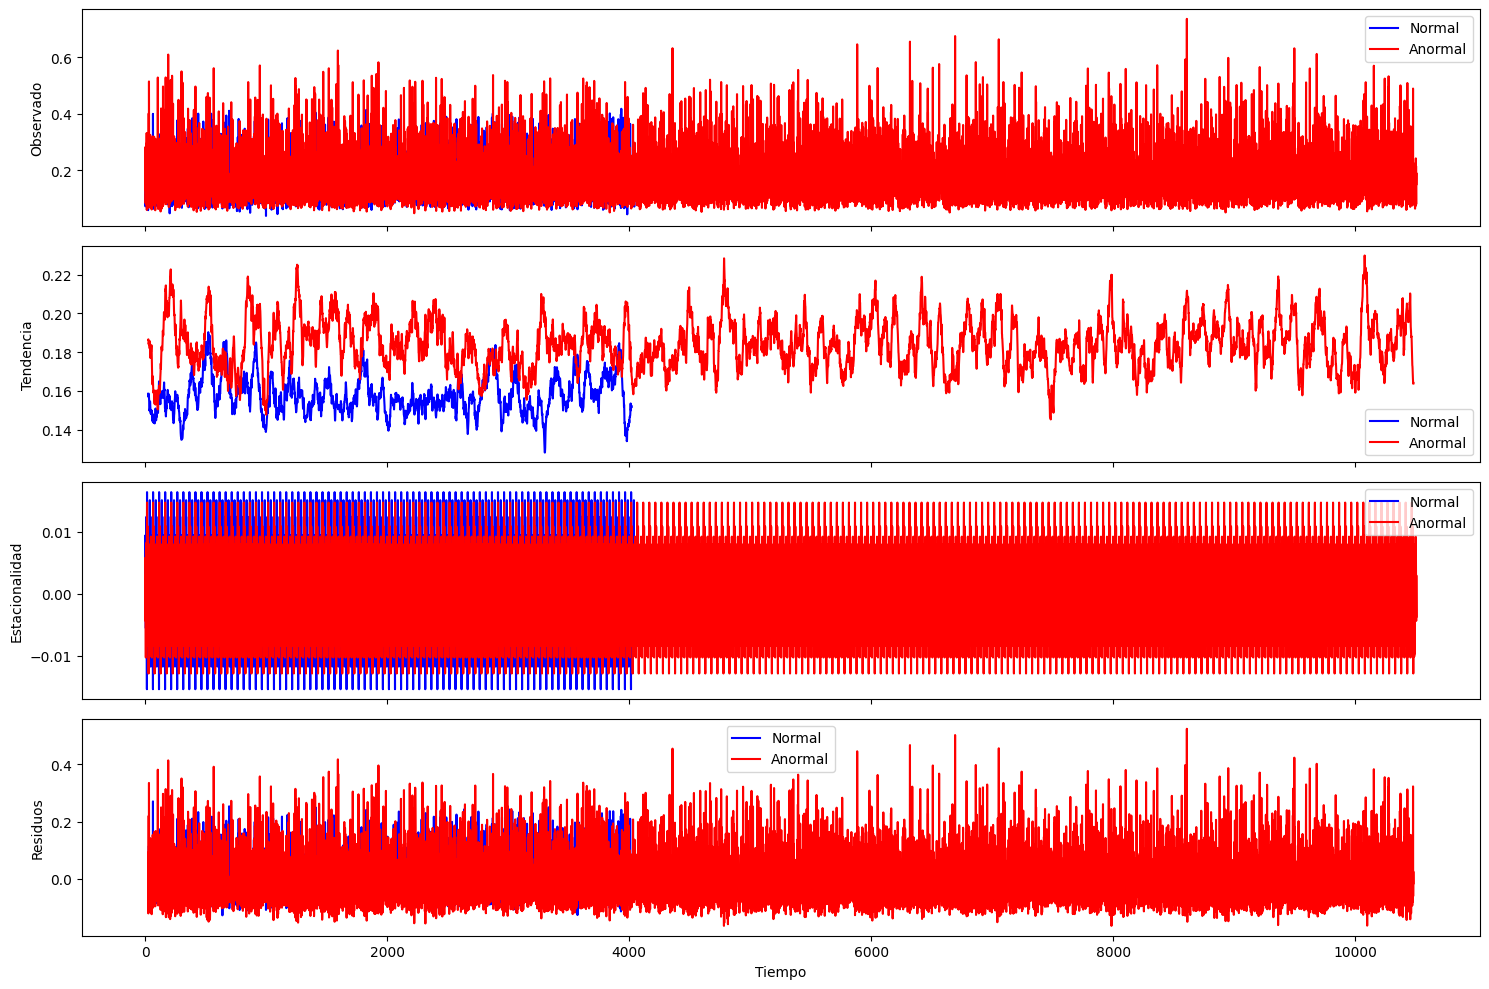

In [19]:
#Descomponer la serie temporal
normal_decomp = seasonal_decompose(dato_normal['value'], model='additive', period=50)
anormal_decomp = seasonal_decompose(dato_anormal['value'], model='additive', period=50)

#Graficar observado
fig, ax = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
normal_decomp.observed.plot(ax=ax[0], color="blue", label="Normal")
anormal_decomp.observed.plot(ax=ax[0], color="red", label="Anormal")
ax[0].set_ylabel("Observado")
ax[0].legend()

#Graficar tendencia
normal_decomp.trend.plot(ax=ax[1], color="blue", label="Normal")
anormal_decomp.trend.plot(ax=ax[1], color="red", label="Anormal")
ax[1].set_ylabel("Tendencia")
ax[1].legend()

#Graficar estacionalidad
normal_decomp.seasonal.plot(ax=ax[2], color="blue", label="Normal")
anormal_decomp.seasonal.plot(ax=ax[2], color="red", label="Anormal")
ax[2].set_ylabel("Estacionalidad")
ax[2].legend()

#Graficar residuos
normal_decomp.resid.plot(ax=ax[3], color="blue", label="Normal")
anormal_decomp.resid.plot(ax=ax[3], color="red", label="Anormal")
ax[3].set_ylabel("Residuos")
ax[3].legend()
ax[3].set_xlabel("Tiempo")
plt.tight_layout()
plt.show()


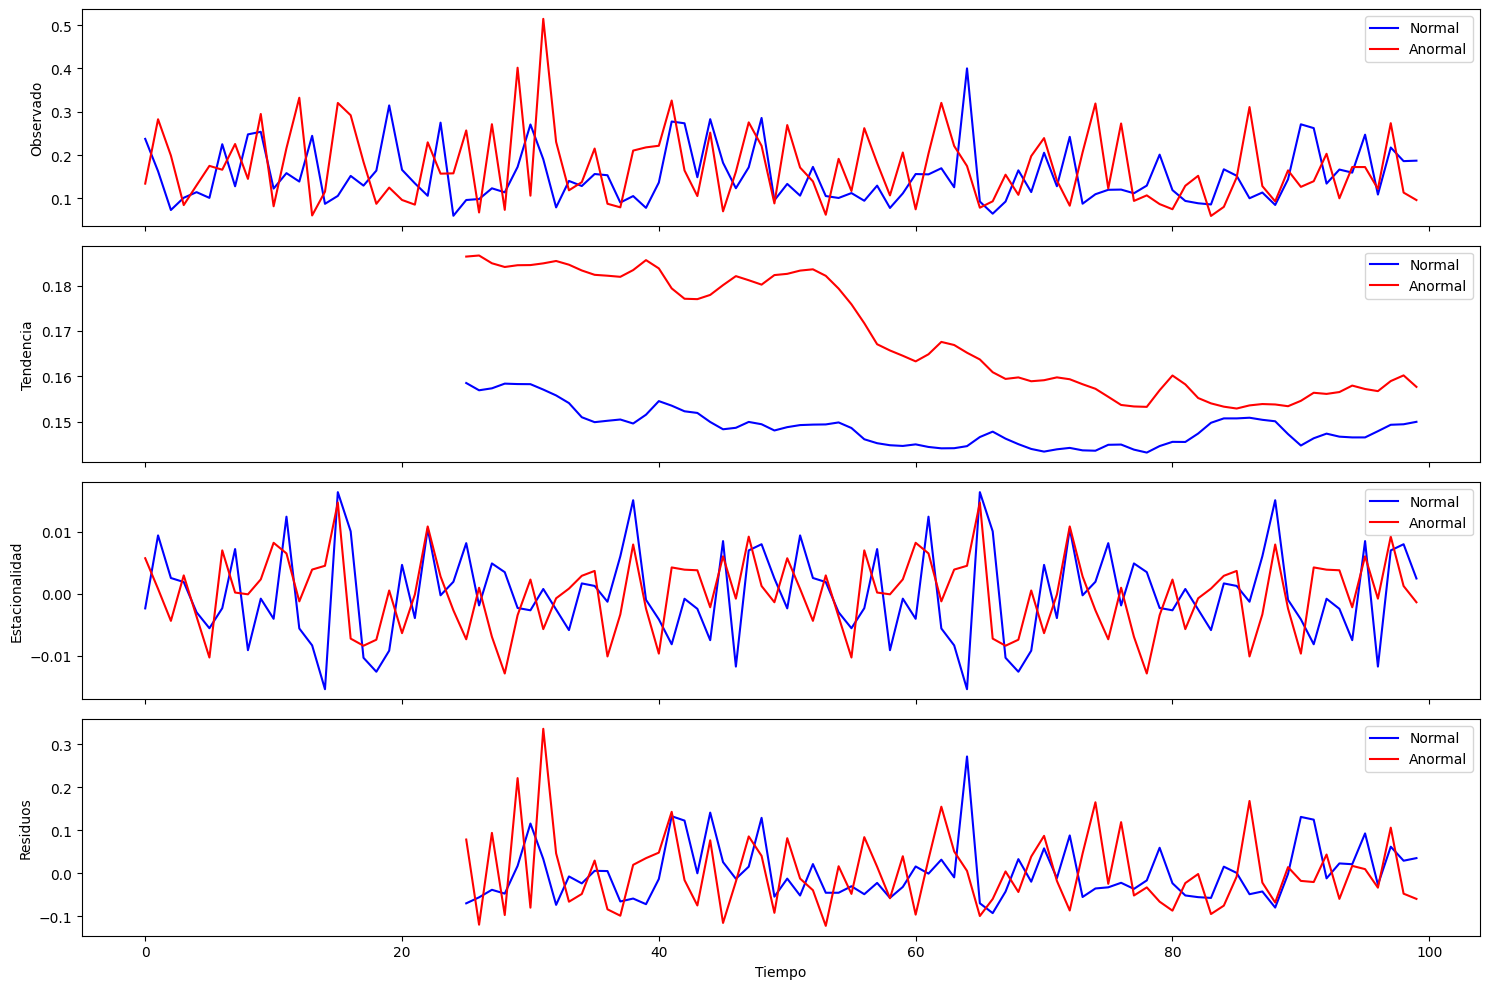

In [20]:
#Graficar segmento representativo
seg = slice(0,100)

#Graficar observado
fig, ax = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
normal_decomp.observed[seg].plot(ax=ax[0], color="blue", label="Normal")
anormal_decomp.observed[seg].plot(ax=ax[0], color="red", label="Anormal")
ax[0].set_ylabel("Observado")
ax[0].legend()

#Graficar tendencia
normal_decomp.trend[seg].plot(ax=ax[1], color="blue", label="Normal")
anormal_decomp.trend[seg].plot(ax=ax[1], color="red", label="Anormal")
ax[1].set_ylabel("Tendencia")
ax[1].legend()

#Graficar estacionalidad
normal_decomp.seasonal[seg].plot(ax=ax[2], color="blue", label="Normal")
anormal_decomp.seasonal[seg].plot(ax=ax[2], color="red", label="Anormal")
ax[2].set_ylabel("Estacionalidad")
ax[2].legend()

#Graficar residuos
normal_decomp.resid[seg].plot(ax=ax[3], color="blue", label="Normal")
anormal_decomp.resid[seg].plot(ax=ax[3], color="red", label="Anormal")
ax[3].set_ylabel("Residuos")
ax[3].legend()
ax[3].set_xlabel("Tiempo")
plt.tight_layout()
plt.show()

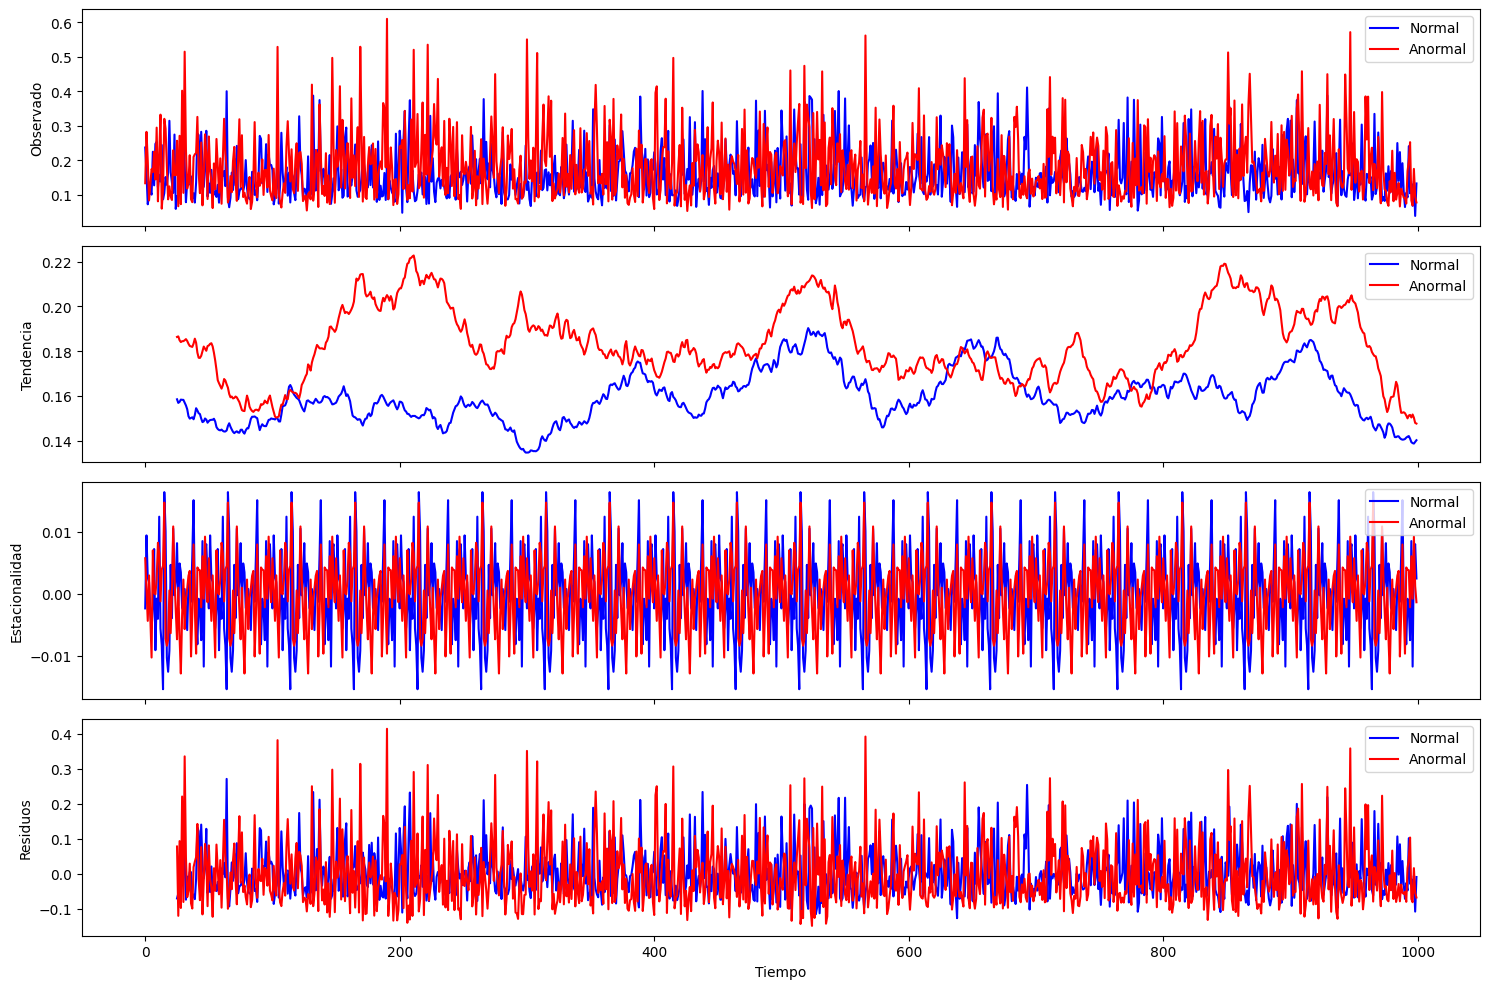

In [21]:
#Graficar segmento representativo
seg = slice(0,1000)

#Graficar observado
fig, ax = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
normal_decomp.observed[seg].plot(ax=ax[0], color="blue", label="Normal")
anormal_decomp.observed[seg].plot(ax=ax[0], color="red", label="Anormal")
ax[0].set_ylabel("Observado")
ax[0].legend()

#Graficar tendencia
normal_decomp.trend[seg].plot(ax=ax[1], color="blue", label="Normal")
anormal_decomp.trend[seg].plot(ax=ax[1], color="red", label="Anormal")
ax[1].set_ylabel("Tendencia")
ax[1].legend()

#Graficar estacionalidad
normal_decomp.seasonal[seg].plot(ax=ax[2], color="blue", label="Normal")
anormal_decomp.seasonal[seg].plot(ax=ax[2], color="red", label="Anormal")
ax[2].set_ylabel("Estacionalidad")
ax[2].legend()

#Graficar residuos
normal_decomp.resid[seg].plot(ax=ax[3], color="blue", label="Normal")
anormal_decomp.resid[seg].plot(ax=ax[3], color="red", label="Anormal")
ax[3].set_ylabel("Residuos")
ax[3].legend()
ax[3].set_xlabel("Tiempo")
plt.tight_layout()
plt.show()

##Medidas estadísticas con ventana rodante

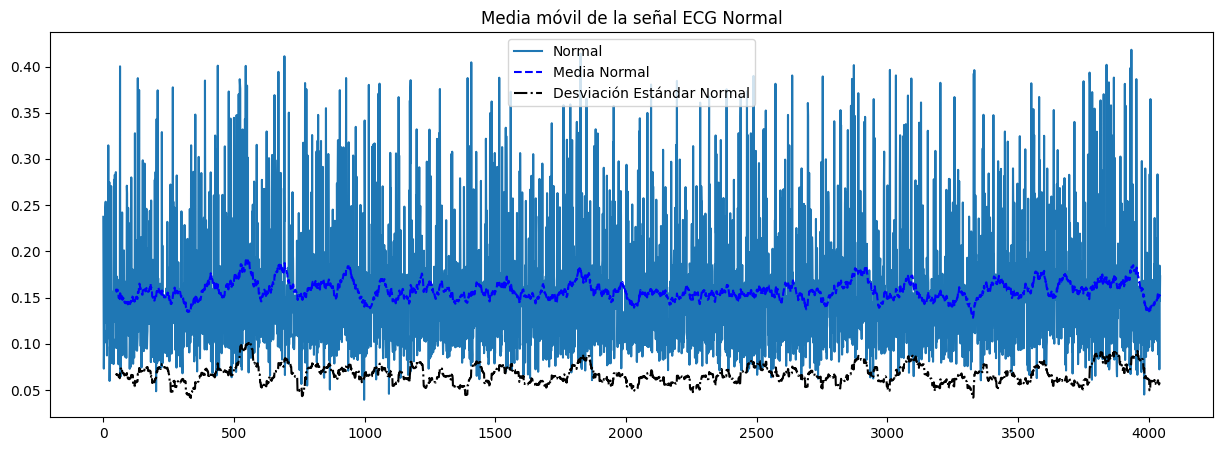

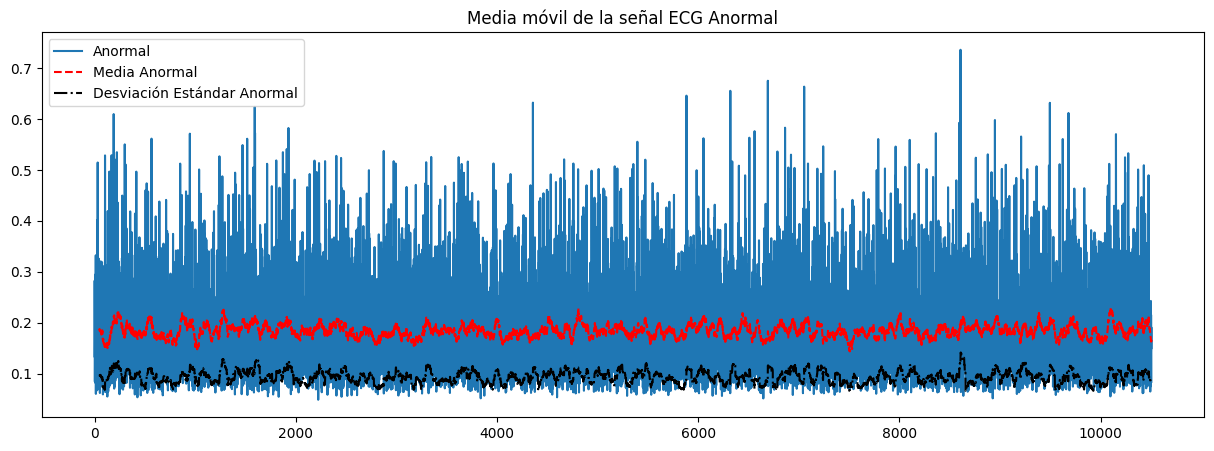

Normal Test Statistic: -62.620318
p-value: 0.000000
Anormal Test Statistic: -102.072570
p-value: 0.000000


In [22]:
rolling_size = 50
rolling_mean_normal = dato_normal['value'].rolling(rolling_size).mean()
rolling_mean_anormal = dato_anormal['value'].rolling(rolling_size).mean()
rolling_std_normal = dato_normal['value'].rolling(rolling_size).std()
rolling_std_anormal = dato_anormal['value'].rolling(rolling_size).std()

#Graficar media móvil de la señal normal
plt.figure(figsize=(15, 5))
plt.plot(dato_normal['value'], label='Normal')
plt.plot(rolling_mean_normal, label='Media Normal', linestyle='--', color='blue')
plt.plot(rolling_std_normal, label='Desviación Estándar Normal', linestyle='-.', color='black')
plt.title('Media móvil de la señal ECG Normal')
plt.legend()
plt.show()

#Graficar media móvil de la señal anormal
plt.figure(figsize=(15, 5))
plt.plot(dato_anormal['value'], label='Anormal')
plt.plot(rolling_mean_anormal, label='Media Anormal', linestyle='--', color='red')
plt.plot(rolling_std_anormal, label='Desviación Estándar Anormal', linestyle='-.', color='black')
plt.title('Media móvil de la señal ECG Anormal')
plt.legend()
plt.show()

#Augmented Dickey-Fuller
result = adfuller(dato_normal['value'])
print('Normal Test Statistic: %f' % result[0])
print('p-value: %f' % result[1])
result = adfuller(dato_anormal['value'])
print('Anormal Test Statistic: %f' % result[0])
print('p-value: %f' % result[1])

Hay estacionariedad tanto para los datos normales y los anormales (valor p menor a 0.05, se rechaza la hipótesis de no estacionariedad). Por otra parte, hay en general más residuos y valores de tendencia más alto para los datos anormales.

###Autocorrelación y Autocorrelación parcial

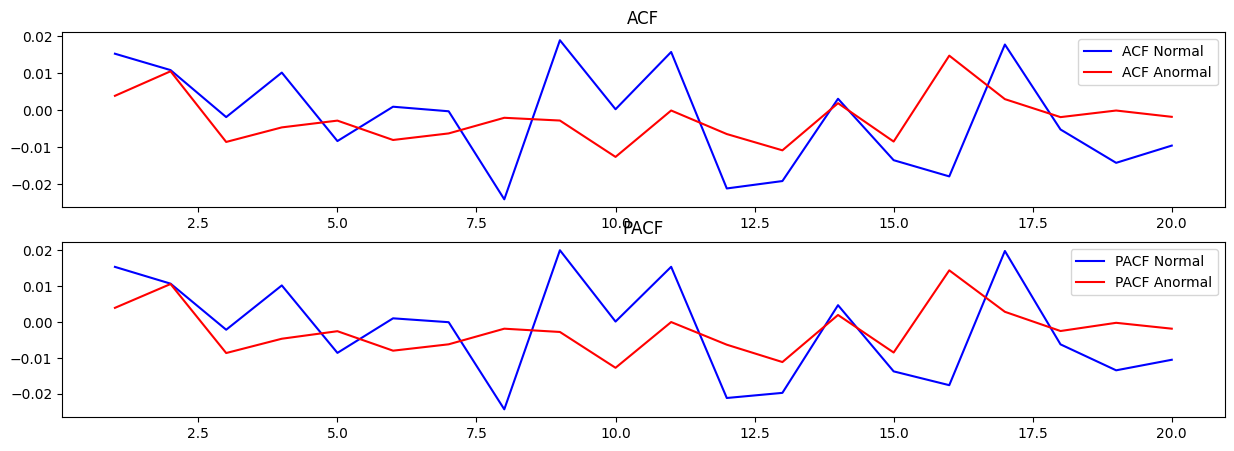

In [23]:
#ACF y PACF para valores anormales
acf_anormal = acf(dato_anormal['value'], nlags=20)[1:]
pacf_anormal = pacf(dato_anormal['value'], nlags=20)[1:]

#ACF y PACF para valores normales
acf_normal = acf(dato_normal['value'], nlags=20)[1:]
pacf_normal = pacf(dato_normal['value'], nlags=20)[1:]

#Graficar ACF y PACF
lags=range(1,21)
plt.figure(figsize=(15, 5))
plt.subplot(211)
plt.plot(lags, acf_normal, label='ACF Normal', color="blue")
plt.plot(lags, acf_anormal, label='ACF Anormal', color="red")
plt.title('ACF')
plt.legend()
plt.plot()

plt.subplot(212)
plt.plot(lags, pacf_normal, label='PACF Normal', color="blue")
plt.plot(lags, pacf_anormal, label='PACF Anormal', color="red")
plt.title('PACF')
plt.legend()
plt.show()

# Isolation Forest

In [25]:
data_normal_iforest = dato_normal.iloc[:,:-1]
data_anormal_iforest = dato_anormal.iloc[:,:-1]

#Reiniciar columnas
data_normal_iforest.columns = [f"Columna_{i}" for i in range(data_normal_iforest.shape[1])]
data_anormal_iforest.columns = [f"Columna_{i}" for i in range(data_anormal_iforest.shape[1])]

#Añadir columna label
data_normal_iforest['label'] = 0
data_anormal_iforest['label'] = 1

#Concatenar
data_iforest = pd.concat([data_normal_iforest, data_anormal_iforest], axis=0).reset_index(drop=True)

#Separar labels y datos, e imputar nulos
y_iforest = data_iforest['label']
data_iforest = data_iforest.drop('label', axis=1)
data_iforest = data_iforest.replace(0, np.nan)
data_iforest = data_iforest.fillna(method='ffill').fillna(method='bfill')

#Eliminar columnas con nulos
data_iforest = data_iforest.dropna(axis=1, how='all')
data_iforest['label'] = y_iforest
if data_iforest.empty:
    print("El DataFrame está vacío.")
labels_iforest = data_iforest['label'].values
data_iforest = data_iforest.drop('label', axis=1)

<ipython-input-25-af986508cc02>:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_iforest = data_iforest.fillna(method='ffill').fillna(method='bfill')


AUPRC:0.8774


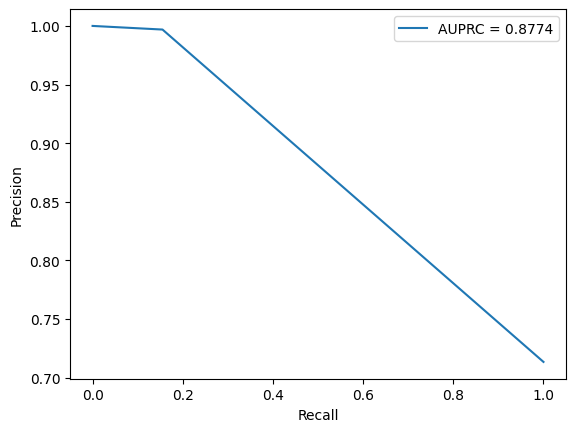

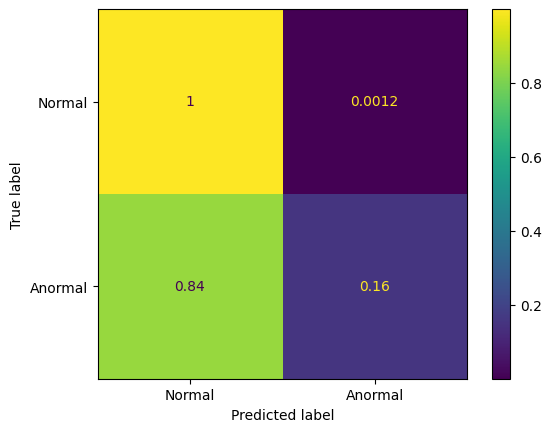

In [ ]:
#Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(data_iforest, labels_iforest, test_size=0.2, random_state=42)

#Escalar
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Entrenar arbol
iforest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iforest.fit(X_train)

#Predecir anomalías y convertir: -1 para anomalía, 1 para normal
y_pred_train = iforest.predict(X_train)
y_pred_test = iforest.predict(X_test)
y_pred_train = np.where(y_pred_train == -1, 1, 0)
y_pred_test = np.where(y_pred_test == -1, 1, 0)

#Curva precisión-recall y AUPRC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_test)
auprc = auc(recall, precision)
print(f"AUPRC:{auprc:.4f}")
plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

#Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()
plt.show()

AUPRC:0.8546


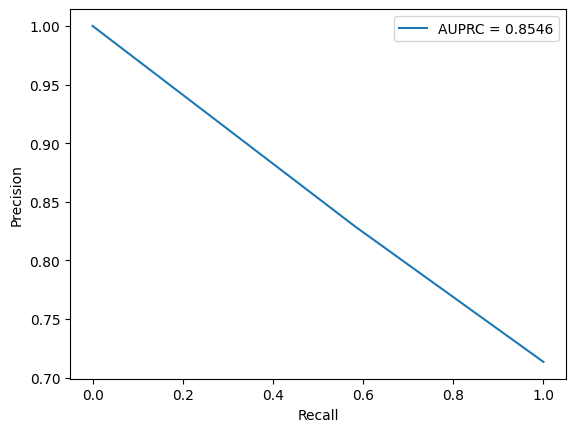

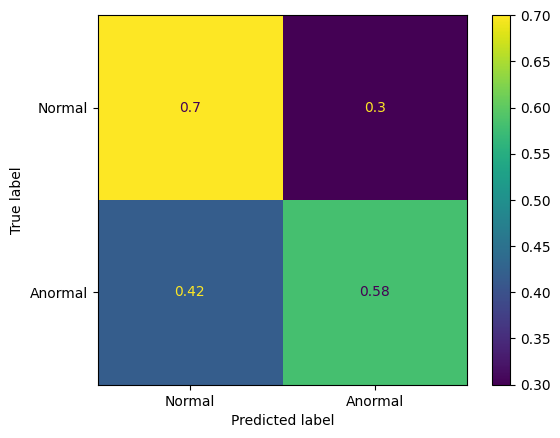

In [ ]:
#Entrenar arbol
iforest = IsolationForest(n_estimators=10, contamination=0.5, random_state=42)
iforest.fit(X_train)

#Predecir anomalías y convertir: -1 para anomalía, 1 para normal
y_pred_train = iforest.predict(X_train)
y_pred_test = iforest.predict(X_test)
y_pred_train = np.where(y_pred_train == -1, 1, 0)
y_pred_test = np.where(y_pred_test == -1, 1, 0)

#Curva precisión-recall y AUPRC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_test)
auprc = auc(recall, precision)
print(f"AUPRC:{auprc:.4f}")
plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

#Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()
plt.show()

AUPRC:0.8886


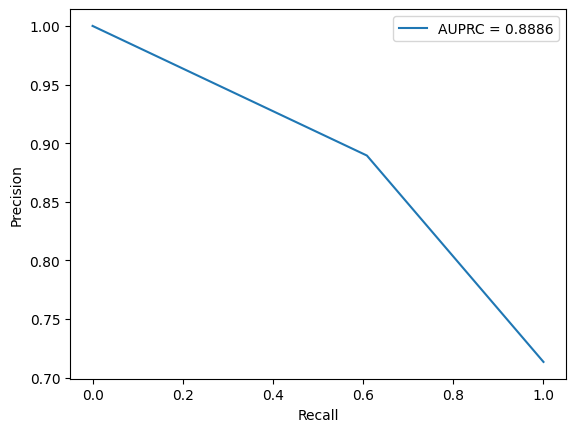

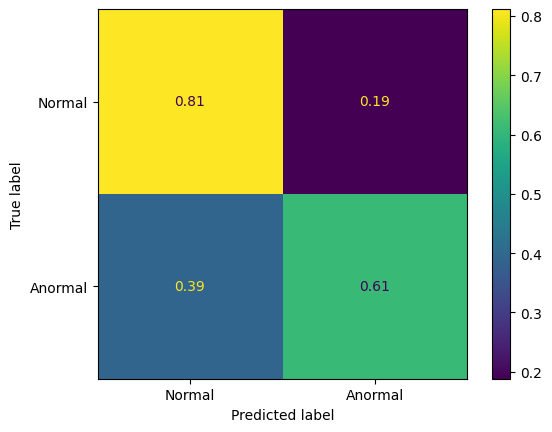

In [ ]:
#Entrenar arbol
iforest = IsolationForest(n_estimators=100, contamination=0.5, random_state=42)
iforest.fit(X_train)

#Predecir anomalías y convertir: -1 para anomalía, 1 para normal
y_pred_train = iforest.predict(X_train)
y_pred_test = iforest.predict(X_test)
y_pred_train = np.where(y_pred_train == -1, 1, 0)
y_pred_test = np.where(y_pred_test == -1, 1, 0)

#Curva precisión-recall y AUPRC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_test)
auprc = auc(recall, precision)
print(f"AUPRC:{auprc:.4f}")
plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

#Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()
plt.show()

AUPRC:0.8681


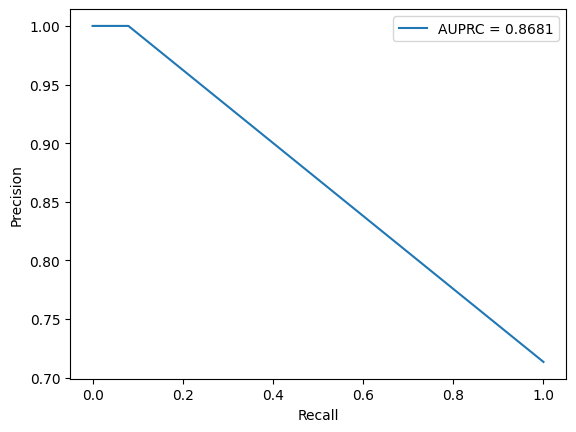

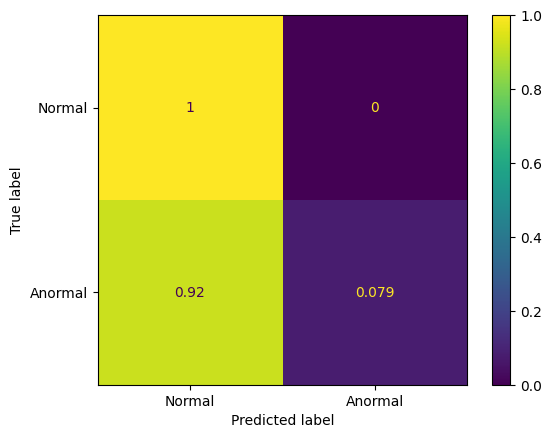

In [ ]:
#Entrenar arbol
iforest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iforest.fit(X_train)

#Predecir anomalías y convertir: -1 para anomalía, 1 para normal
y_pred_train = iforest.predict(X_train)
y_pred_test = iforest.predict(X_test)
y_pred_train = np.where(y_pred_train == -1, 1, 0)
y_pred_test = np.where(y_pred_test == -1, 1, 0)

#Curva precisión-recall y AUPRC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_test)
auprc = auc(recall, precision)
print(f"AUPRC:{auprc:.4f}")
plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

#Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()
plt.show()

#Autoencoder

In [ ]:
#Autoencoder
autoencoder = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(X_train.shape[1], activation='sigmoid')
])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │          12,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 187)                 │          12,155 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,379 (110.86 KB)

 Trainable params: 28,379 (110.86 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2)
autoencoder.summary()

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0072 - val_loss: 0.0075
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072 - val_loss: 0.0074
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0073 - val_loss: 0.0075
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0072 - val_loss: 0.0074
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072 - val_loss: 0.0074
Epoch 9/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 10/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 11/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071 - val_loss: 0.0073
Epoch 12/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │          12,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 187)                 │          12,155 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,139 (332.58 KB)

 Trainable params: 28,379 (110.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 56,760 (221.72 KB)

In [ ]:
reconst = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconst, 2), axis=1)
mae = np.mean(np.abs(X_test - reconst), axis=1)
threshold = np.percentile(mse, 95)
(mse, mae, threshold)

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(array([0.00425676, 0.00339371, 0.0049284 , ..., 0.00619572, 0.01044555,
        0.00331546]),
 array([0.04268129, 0.03777676, 0.04825049, ..., 0.05903234, 0.06677711,
        0.03758513]),
 0.0138540678940865)

In [ ]:
#Curva Precision-Recall y AUC
precision, recall, thresholds = precision_recall_curve(y_test, mae)
auprc = auc(recall, precision)
print(f"AUPRC:{auprc:.4f}")

AUPRC:0.8823


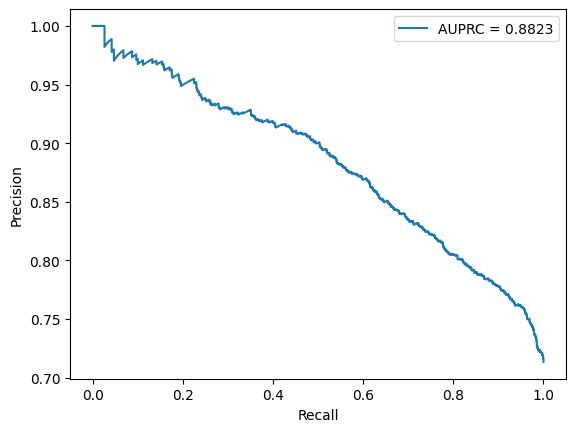

In [ ]:
plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

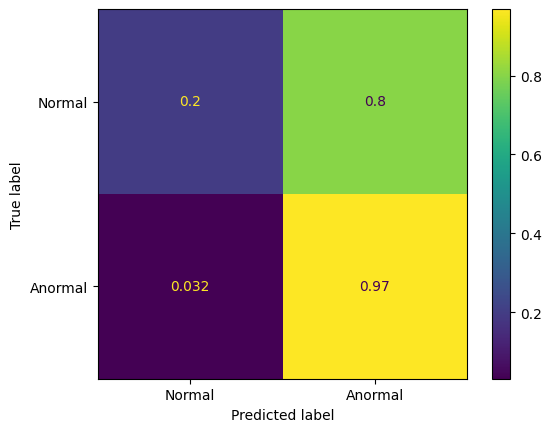

In [ ]:
mejor_tresh = thresholds[np.argmax(precision*recall)]
y_pred = (mae > mejor_tresh).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()
plt.show()

##Treshold

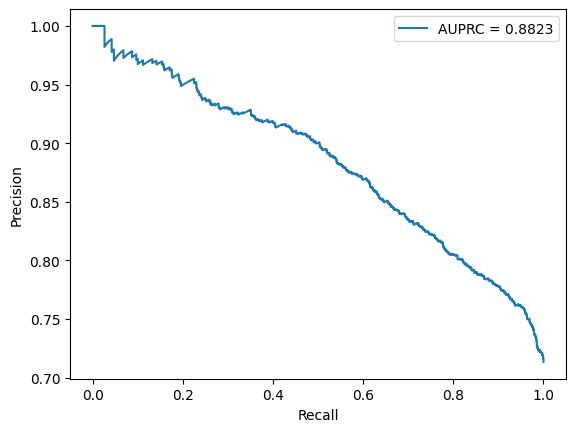

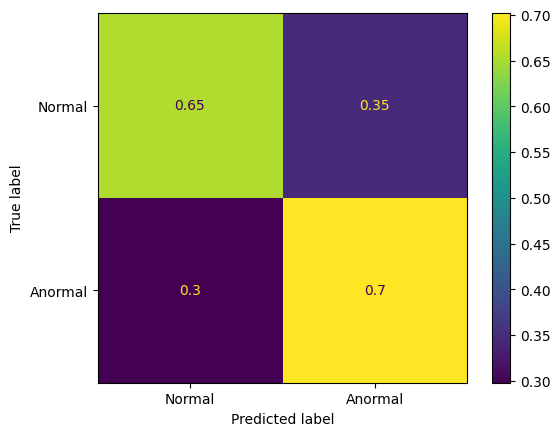

In [ ]:
mejor_tresh = np.percentile(mae, 40)

plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

y_pred = (mae > mejor_tresh).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()
plt.show()

#Autoencoder con LSTM

##MSE para función de pérdida

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
class_weight_dict

{0: 1.8125194643413267, 1: 0.690473365761063}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_iforest, labels_iforest, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Timesteps
timesteps = 10
n_features = X_train.shape[1] // timesteps
X_train = X_train[:, :n_features * timesteps]
X_test = X_test[:, :n_features * timesteps]
X_train = X_train.reshape(X_train.shape[0], timesteps, n_features)
X_test = X_test.reshape(X_test.shape[0], timesteps, n_features)

lstm_autoencoder = Sequential([
    LSTM(128, activation='relu', input_shape=(timesteps, n_features), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    RepeatVector(timesteps),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(n_features))
])
lstm_autoencoder.compile(optimizer='adam', loss='mse')
lstm_autoencoder.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 10, 128)             │          75,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 10, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 10, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 10, 18)              │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 258,834 (1011.07 KB)

 Trainable params: 258,834 (1011.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2)
lstm_autoencoder.summary()

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - loss: 0.0536 - val_loss: 0.0260
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 0.0253 - val_loss: 0.0233
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 0.0228 - val_loss: 0.0212
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - loss: 0.0208 - val_loss: 0.0195
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - loss: 0.0187 - val_loss: 0.0180
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - loss: 0.0176 - val_loss: 0.0166
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - loss: 0.0163 - val_loss: 0.0156
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - loss: 0.0151 - val_loss: 0.0144
Epoch 9/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 0.0138 - val_loss: 0.0131
Epoch 10/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - loss: 0.0127 - val_loss: 0.0122
Epoch 11/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - loss: 0.0118 - val_loss: 0.0114
Epoch 12/50
291/291 ━━━━━━━━━━

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 10, 128)             │          75,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 10, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 10, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 10, 18)              │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 776,504 (2.96 MB)

 Trainable params: 258,834 (1011.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 517,670 (1.97 MB)

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
AUPRC:0.9112


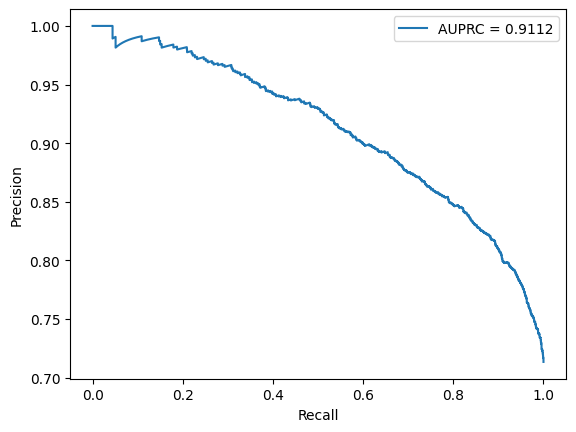

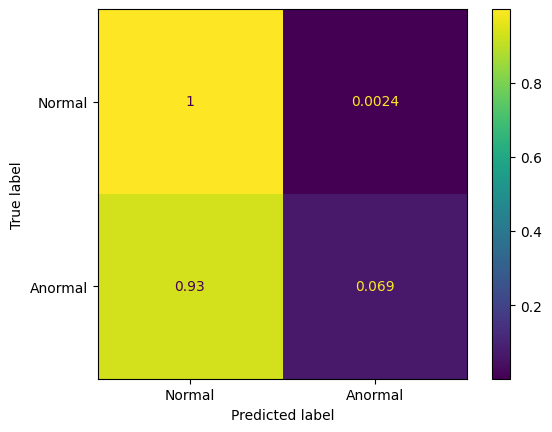

In [ ]:
reconst = lstm_autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconst, 2), axis=1).mean(axis=1)
mae = np.mean(np.abs(X_test - reconst), axis=1).mean(axis=1)
precision, recall, thresholds = precision_recall_curve(y_test, mae)
auprc = auc(recall, precision)
print(f"AUPRC:{auprc:.4f}")
plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
tresh = np.percentile(mae, 95)
y_pred = (mae > tresh).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()

### Con timestep diferente

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_iforest, labels_iforest, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Timesteps
timesteps = 20
n_features = X_train.shape[1] // timesteps
X_train = X_train[:, :n_features * timesteps]
X_test = X_test[:, :n_features * timesteps]
X_train = X_train.reshape(X_train.shape[0], timesteps, n_features)
X_test = X_test.reshape(X_test.shape[0], timesteps, n_features)

lstm_autoencoder = Sequential([
    LSTM(128, activation='relu', input_shape=(timesteps, n_features), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    RepeatVector(timesteps),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(n_features))
])
lstm_autoencoder.compile(optimizer='adam', loss='mse')
lstm_autoencoder.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 20, 128)             │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_3 (RepeatVector)       │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 20, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 20, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 9)               │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 253,065 (988.54 KB)

 Trainable params: 253,065 (988.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2)
lstm_autoencoder.summary()

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 45s 104ms/step - loss: 0.0529 - val_loss: 0.0271
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 26s 90ms/step - loss: 0.0265 - val_loss: 0.0254
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - loss: 0.0244 - val_loss: 0.0233
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 41s 87ms/step - loss: 0.0229 - val_loss: 0.0217
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 43s 93ms/step - loss: 0.0214 - val_loss: 0.0204
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - loss: 0.0201 - val_loss: 0.0200
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - loss: 0.0192 - val_loss: 0.0187
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - loss: 0.0183 - val_loss: 0.0183
Epoch 9/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - loss: 0.0178 - val_loss: 0.0176
Epoch 10/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 40s 94ms/step - loss: 0.0174 - val_loss: 0.0171
Epoch 11/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 41s 94ms/step - loss: 0.0167 - val_loss: 0.0163
Epoch 12/50
291/291 ━━━━━━━━━

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 20, 128)             │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_3 (RepeatVector)       │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 20, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 20, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 9)               │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 759,197 (2.90 MB)

 Trainable params: 253,065 (988.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 506,132 (1.93 MB)

91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
AUPRC:0.9047


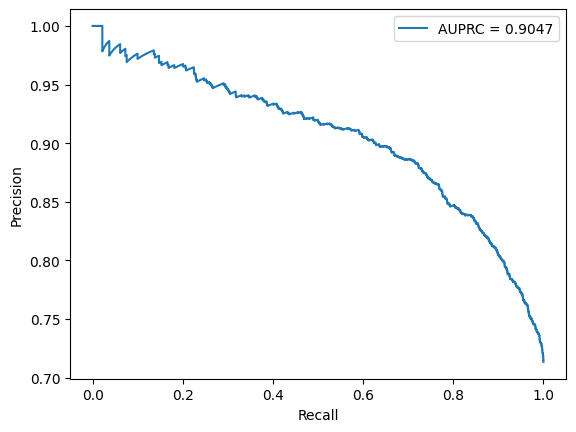

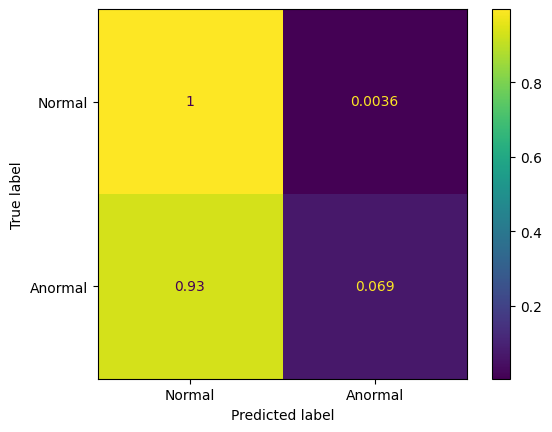

In [ ]:
reconst = lstm_autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconst, 2), axis=1).mean(axis=1)
mae = np.mean(np.abs(X_test - reconst), axis=1).mean(axis=1)
precision, recall, thresholds = precision_recall_curve(y_test, mae)
auprc = auc(recall, precision)
print(f"AUPRC:{auprc:.4f}")
plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
tresh = np.percentile(mae, 95)
y_pred = (mae > tresh).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()

In [ ]:
cm

array([[0.99640288, 0.00359712],
       [0.93111753, 0.06888247]])

##MAE como función de pérdida

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_iforest, labels_iforest, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Timesteps
timesteps = 10
n_features = X_train.shape[1] // timesteps
X_train = X_train[:, :n_features * timesteps]
X_test = X_test[:, :n_features * timesteps]
X_train = X_train.reshape(X_train.shape[0], timesteps, n_features)
X_test = X_test.reshape(X_test.shape[0], timesteps, n_features)

lstm_autoencoder = Sequential([
    LSTM(128, activation='relu', input_shape=(timesteps, n_features), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    RepeatVector(timesteps),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(n_features))
])
lstm_autoencoder.compile(optimizer='adam', loss='mae')
lstm_autoencoder.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 10, 128)             │          75,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_5 (RepeatVector)       │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 10, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 10, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 10, 18)              │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 258,834 (1011.07 KB)

 Trainable params: 258,834 (1011.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2)
lstm_autoencoder.summary()

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - loss: 0.1579 - val_loss: 0.1059
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 0.1035 - val_loss: 0.0955
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - loss: 0.0946 - val_loss: 0.0909
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - loss: 0.0898 - val_loss: 0.0849
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.0839 - val_loss: 0.0819
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - loss: 0.0800 - val_loss: 0.0767
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 0.0761 - val_loss: 0.0752
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - loss: 0.0733 - val_loss: 0.0732
Epoch 9/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 0.0724 - val_loss: 0.0714
Epoch 10/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 0.0708 - val_loss: 0.0692
Epoch 11/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - loss: 0.0685 - val_loss: 0.0680
Epoch 12/50
291/291 ━━━━━━━━━━

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 10, 128)             │          75,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_5 (RepeatVector)       │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 10, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 10, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 10, 18)              │           2,322 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 776,504 (2.96 MB)

 Trainable params: 258,834 (1011.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 517,670 (1.97 MB)

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
AUPRC:0.8964


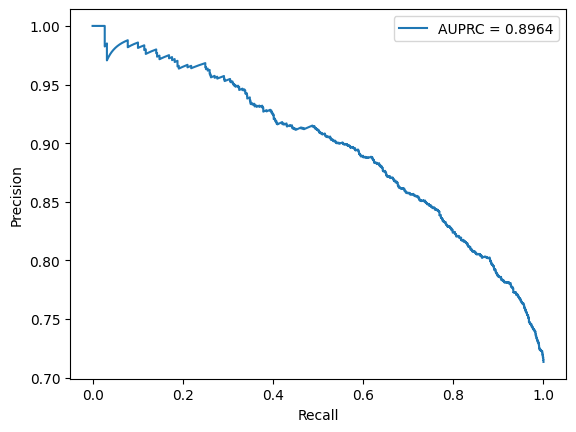

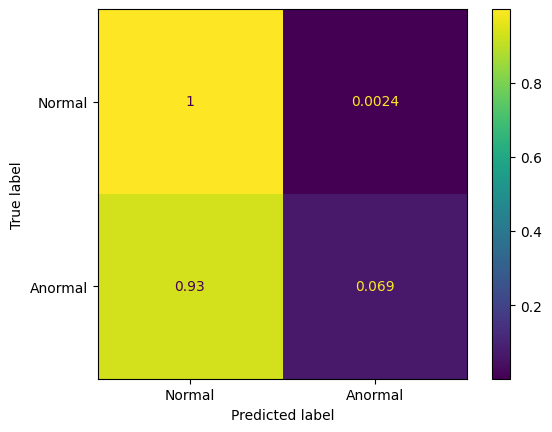

In [ ]:
reconst = lstm_autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconst, 2), axis=1).mean(axis=1)
mae = np.mean(np.abs(X_test - reconst), axis=1).mean(axis=1)
precision, recall, thresholds = precision_recall_curve(y_test, mae)
auprc = auc(recall, precision)
print(f"AUPRC:{auprc:.4f}")
plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
tresh = np.percentile(mae, 95)
y_pred = (mae > tresh).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()

##Threshold a 40%

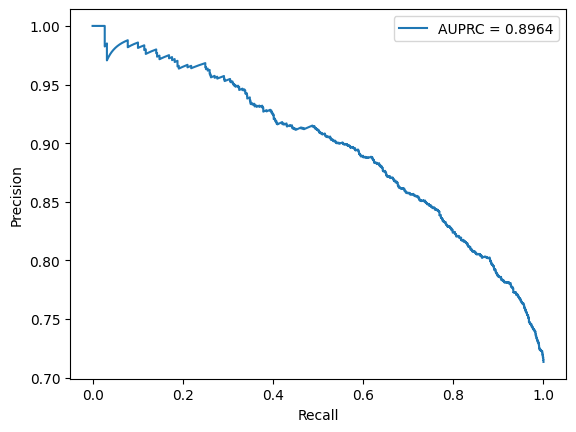

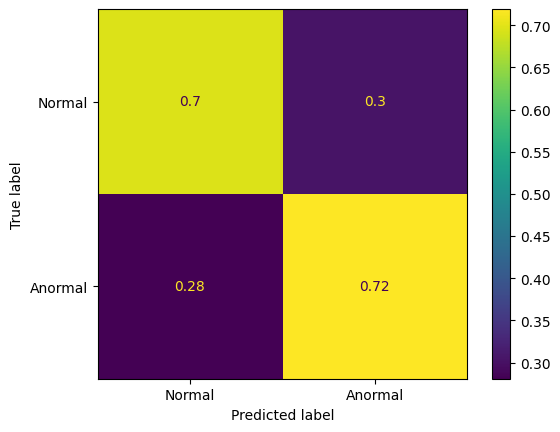

In [ ]:
best_tresh = np.percentile(mae, 40)
plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
y_pred = (mae > best_tresh).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()
plt.show()

##Threshold basado en la curva precision-recall

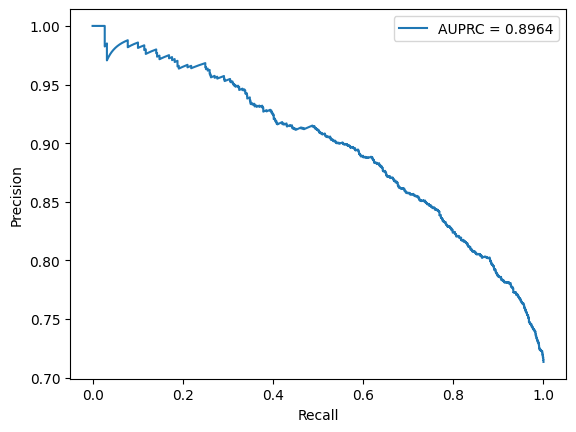

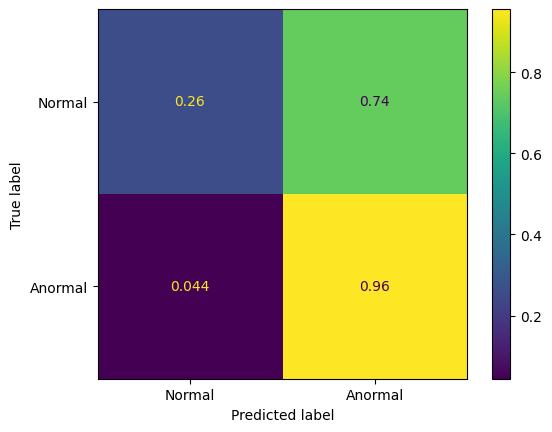

In [ ]:
best_tresh = thresholds[np.argmax(precision*recall)]
plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
y_pred = (mae > best_tresh).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()
plt.show()

#Autoencoder con LSTM y extraccióon de características con CNN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_iforest, labels_iforest, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Timesteps
timesteps = 30
n_features = X_train.shape[1] // timesteps
X_train = X_train[:, :n_features * timesteps]
X_test = X_test[:, :n_features * timesteps]
X_train = X_train.reshape(X_train.shape[0], timesteps, n_features)
X_test = X_test.reshape(X_test.shape[0], timesteps, n_features)

In [ ]:
#CNN para extracción de características
cnn_extractor = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)),
    MaxPooling1D(pool_size=2),
    Flatten()
])
cnn_extractor.compile(optimizer='adam', loss='mse')
cnn_extractor.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 28, 32)              │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 14, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 448)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 608 (2.38 KB)

 Trainable params: 608 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Extraer características de los datos
#No se ajusta el modelo para extraer las características originales
X_train_features = cnn_extractor.predict(X_train)
X_train_features = X_train_features.reshape((X_train_features.shape[0], 1, -1))
X_test_features = cnn_extractor.predict(X_test)
X_test_features = X_test_features.reshape((X_test_features.shape[0], 1, -1))
X_train_features.shape

364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(11640, 1, 448)

In [ ]:
X_test_features.shape

(2910, 1, 448)

In [ ]:
#Autoencoder
lstm_autoencoder = Sequential([
    LSTM(128, activation='relu', input_shape=(1, X_train_features.shape[2]), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    RepeatVector(1),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_train_features.shape[2]))
    ])
lstm_autoencoder.compile(optimizer='adam', loss='mse')
lstm_autoencoder.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 1, 128)              │         295,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_6 (RepeatVector)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 1, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 1, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 1, 448)              │          57,792 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 534,464 (2.04 MB)

 Trainable params: 534,464 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_autoencoder.fit(X_train_features, X_train_features, epochs=50, batch_size=32, validation_split=0.2)
lstm_autoencoder.summary()

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.0121 - val_loss: 0.0045
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 11/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 12/50
291/291 ━━━━━━━━━━━━━━━━━━━━

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 1, 128)              │         295,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_6 (RepeatVector)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 1, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 1, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 1, 448)              │          57,792 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,603,394 (6.12 MB)

 Trainable params: 534,464 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,068,930 (4.08 MB)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
AUPRC:0.8929


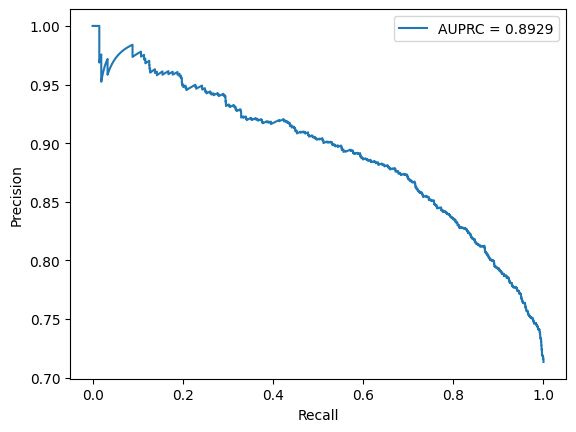

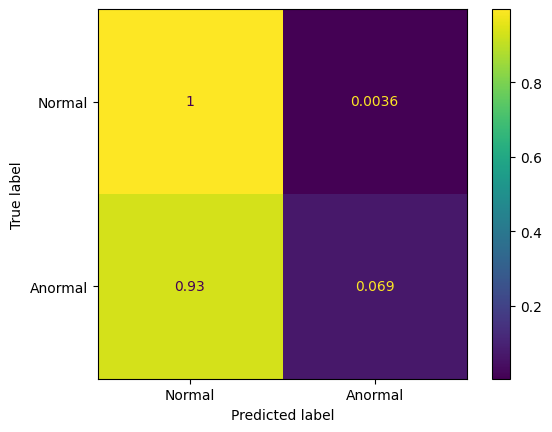

In [ ]:
reconst = lstm_autoencoder.predict(X_test_features)
mae = np.mean(np.abs(X_test_features - reconst), axis=2).flatten()
precision, recall, thresholds = precision_recall_curve(y_test, mae)
auprc = auc(recall, precision)
print(f"AUPRC:{auprc:.4f}")
plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
tresh = np.percentile(mae, 95)
y_pred = (mae > tresh).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()
plt.show()

##Treshold a 40%

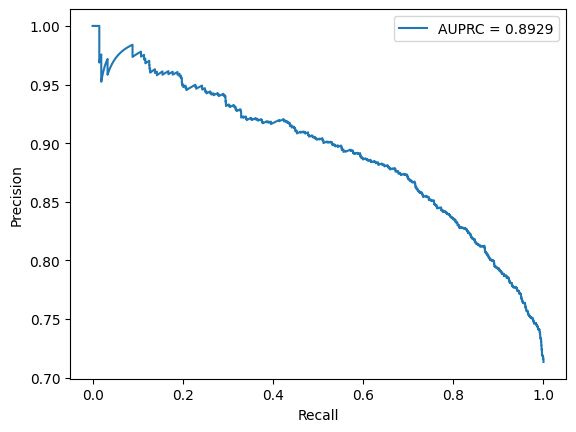

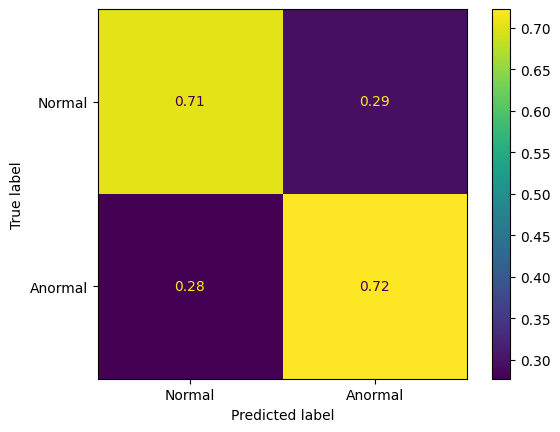

In [ ]:
best_tresh = np.percentile(mae, 40)
plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
y_pred = (mae > best_tresh).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()
plt.show()

##Timestep a 10

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_iforest, labels_iforest, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Timesteps
timesteps = 10
n_features = X_train.shape[1] // timesteps
X_train = X_train[:, :n_features * timesteps]
X_test = X_test[:, :n_features * timesteps]
X_train = X_train.reshape(X_train.shape[0], timesteps, n_features)
X_test = X_test.reshape(X_test.shape[0], timesteps, n_features)

#CNN para extracción de características
cnn_extractor = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)),
    MaxPooling1D(pool_size=2),
    Flatten()
])
cnn_extractor.compile(optimizer='adam', loss='mse')
cnn_extractor.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 8, 32)               │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,760 (6.88 KB)

 Trainable params: 1,760 (6.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_autoencoder.fit(X_train_features, X_train_features, epochs=50, batch_size=32, validation_split=0.2)
lstm_autoencoder.summary()

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 6.3679e-04 - val_loss: 6.7082e-04
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 6.3437e-04 - val_loss: 6.6460e-04
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 6.3014e-04 - val_loss: 6.5666e-04
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 6.2079e-04 - val_loss: 6.5368e-04
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 6.2834e-04 - val_loss: 6.4576e-04
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 6.1489e-04 - val_loss: 6.4495e-04
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 6.0990e-04 - val_loss: 6.4485e-04
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 6.0838e-04 - val_loss: 6.3210e-04
Epoch 9/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 6.0051e-04 - val_loss: 6.3805e-04
Epoch 10/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 5.9841e-04 - val_loss: 6.3195e-04
Epoch 11/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 13m

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 1, 128)              │         295,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_6 (RepeatVector)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 1, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 1, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 1, 448)              │          57,792 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,603,394 (6.12 MB)

 Trainable params: 534,464 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,068,930 (4.08 MB)

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
AUPRC:0.9014


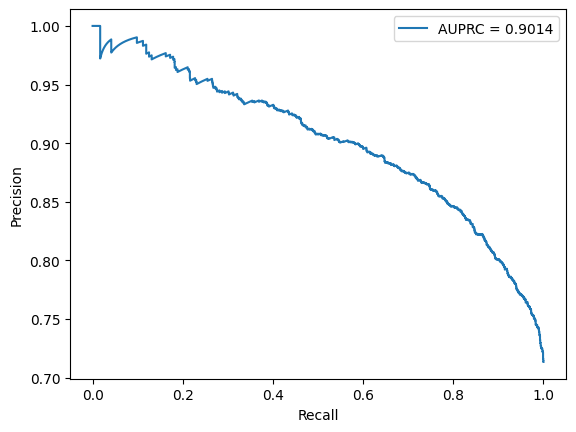

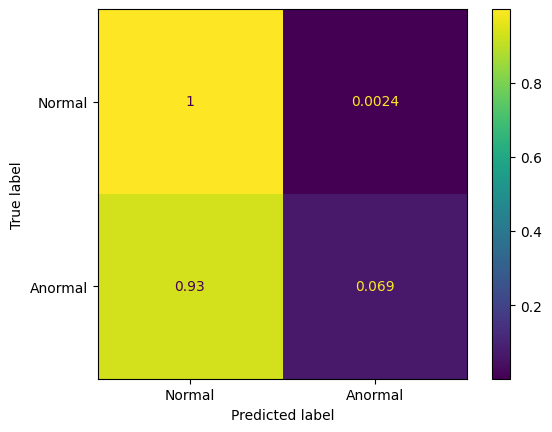

In [ ]:
reconst = lstm_autoencoder.predict(X_test_features)
mae = np.mean(np.abs(X_test_features - reconst), axis=2).flatten()
precision, recall, thresholds = precision_recall_curve(y_test, mae)
auprc = auc(recall, precision)
print(f"AUPRC:{auprc:.4f}")
plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
tresh = np.percentile(mae, 95)
y_pred = (mae > tresh).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()
plt.show()

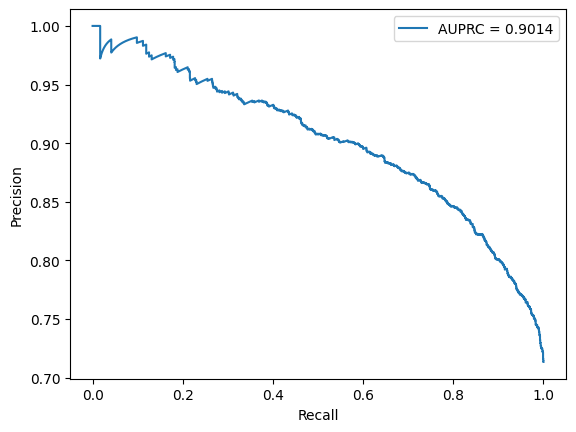

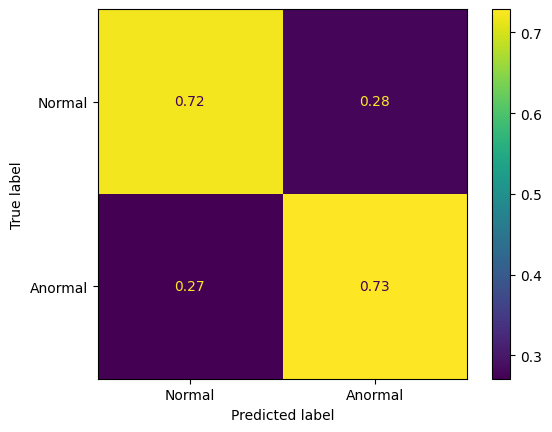

In [ ]:
best_tresh = np.percentile(mae, 40)
plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
y_pred = (mae > best_tresh).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()
plt.show()

#Autoencoder con GRU y extracción de características con CNN

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data_iforest, labels_iforest, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Timesteps
timesteps = 30
n_features = X_train.shape[1] // timesteps
X_train = X_train[:, :n_features * timesteps]
X_test = X_test[:, :n_features * timesteps]
X_train = X_train.reshape(X_train.shape[0], timesteps, n_features)
X_test = X_test.reshape(X_test.shape[0], timesteps, n_features)

In [27]:
#CNN para extracción de características
cnn_extractor = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)),
    MaxPooling1D(pool_size=2),
    Flatten()
])
cnn_extractor.compile(optimizer='adam', loss='mse')
cnn_extractor.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 28, 32)              │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 14, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 448)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 608 (2.38 KB)

 Trainable params: 608 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
#Extraer características de los datos
#No se ajusta el modelo para extraer las características originales
X_train_features = cnn_extractor.predict(X_train)
X_train_features = X_train_features.reshape((X_train_features.shape[0], 1, -1))
X_test_features = cnn_extractor.predict(X_test)
X_test_features = X_test_features.reshape((X_test_features.shape[0], 1, -1))
X_train_features.shape

364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(11640, 1, 448)

In [29]:
#Autoencoder
gru_autoencoder = Sequential([
    GRU(128, activation='relu', input_shape=(1, X_train_features.shape[2]), return_sequences=True),
    GRU(64, activation='relu', return_sequences=False),
    RepeatVector(1),
    GRU(64, activation='relu', return_sequences=True),
    GRU(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_train_features.shape[2]))
    ])
gru_autoencoder.compile(optimizer='adam', loss='mse')
gru_autoencoder.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 1, 128)              │         221,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 1, 64)               │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 1, 128)              │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 1, 448)              │          57,792 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 416,448 (1.59 MB)

 Trainable params: 416,448 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
gru_autoencoder.fit(X_train_features, X_train_features, epochs=50, batch_size=32, validation_split=0.2)
gru_autoencoder.summary()

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0102 - val_loss: 0.0039
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 9/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 11/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 12/50
291/291 ━━━━━━━━━━━━━━━━━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 1, 128)              │         221,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 1, 64)               │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 1, 128)              │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 1, 448)              │          57,792 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,249,346 (4.77 MB)

 Trainable params: 416,448 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 832,898 (3.18 MB)

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step
AUPRC:0.8875


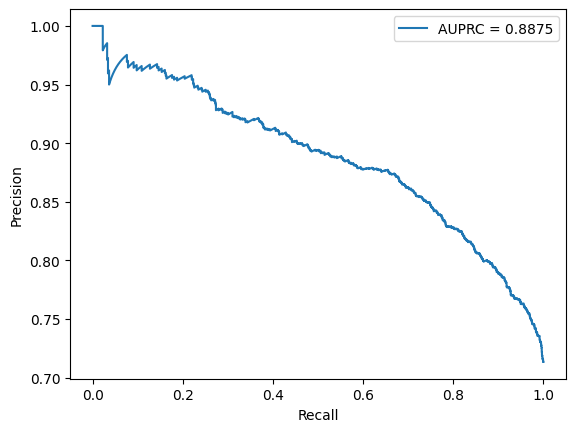

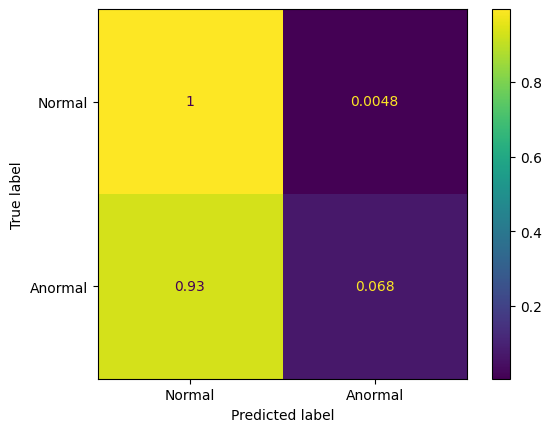

In [31]:
reconst = gru_autoencoder.predict(X_test_features)
mae = np.mean(np.abs(X_test_features - reconst), axis=2).flatten()
precision, recall, thresholds = precision_recall_curve(y_test, mae)
auprc = auc(recall, precision)
print(f"AUPRC:{auprc:.4f}")
plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
tresh = np.percentile(mae, 95)
y_pred = (mae > tresh).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()
plt.show()

##Treshold a 40%

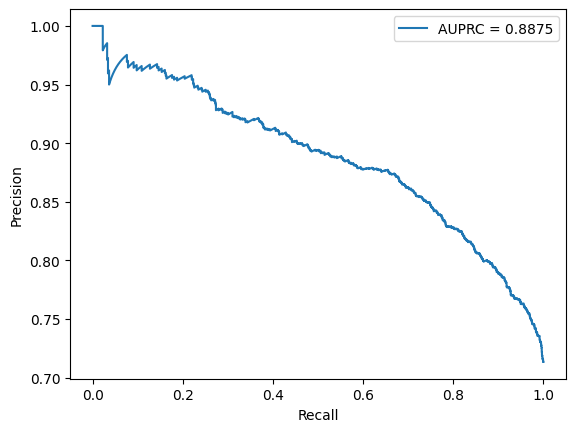

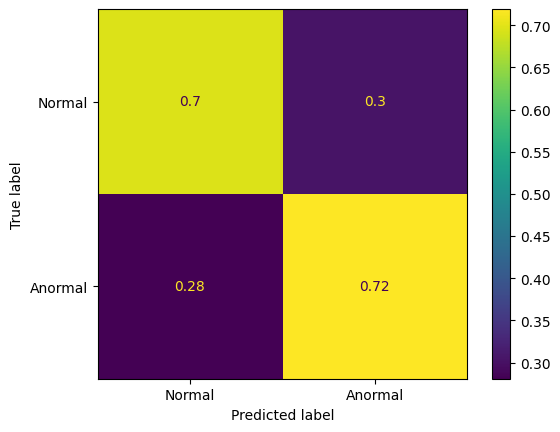

In [32]:
best_tresh = np.percentile(mae, 40)
plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
y_pred = (mae > best_tresh).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()
plt.show()

##Treshold basado en la curva precision-recall

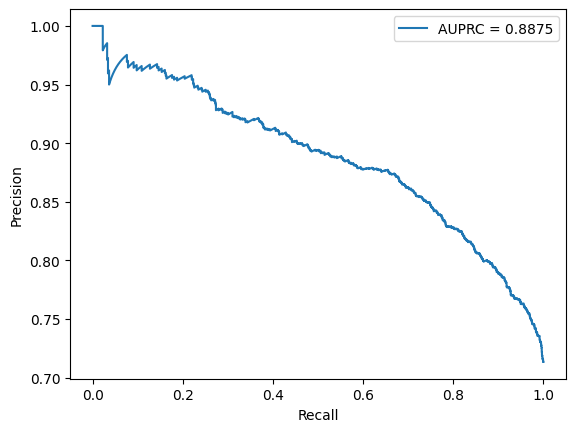

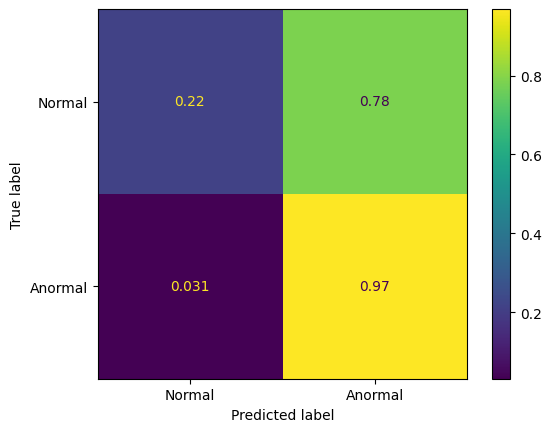

In [38]:
best_tresh = thresholds[np.argmax(precision*recall)]
plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
y_pred = (mae > best_tresh).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()
plt.show()

##Timestep a 10  y treshold a 40%

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data_iforest, labels_iforest, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Timesteps
timesteps = 10
n_features = X_train.shape[1] // timesteps
X_train = X_train[:, :n_features * timesteps]
X_test = X_test[:, :n_features * timesteps]
X_train = X_train.reshape(X_train.shape[0], timesteps, n_features)
X_test = X_test.reshape(X_test.shape[0], timesteps, n_features)

In [45]:
#CNN para extracción de características
cnn_extractor = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(timesteps, n_features)),
    MaxPooling1D(pool_size=2),
    Flatten()
])
cnn_extractor.compile(optimizer='adam', loss='mse')
cnn_extractor.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 8, 32)               │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 4, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,760 (6.88 KB)

 Trainable params: 1,760 (6.88 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
#Extraer características de los datos
#No se ajusta el modelo para extraer las características originales
X_train_features = cnn_extractor.predict(X_train)
X_train_features = X_train_features.reshape((X_train_features.shape[0], 1, -1))
X_test_features = cnn_extractor.predict(X_test)
X_test_features = X_test_features.reshape((X_test_features.shape[0], 1, -1))
X_train_features.shape

364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(11640, 1, 128)

In [47]:
#Autoencoder
lstm_autoencoder = Sequential([
    LSTM(128, activation='relu', input_shape=(1, X_train_features.shape[2]), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    RepeatVector(1),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_train_features.shape[2]))
    ])
lstm_autoencoder.compile(optimizer='adam', loss='mse')
lstm_autoencoder.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 1, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 1, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 1, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 1, 128)              │          16,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 329,344 (1.26 MB)

 Trainable params: 329,344 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
lstm_autoencoder.fit(X_train_features, X_train_features, epochs=50, batch_size=32, validation_split=0.2)
lstm_autoencoder.summary()

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0342 - val_loss: 0.0087
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0080 - val_loss: 0.0071
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 9/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 10/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 11/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 12/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 1, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 1, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 1, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 1, 128)              │          16,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 988,034 (3.77 MB)

 Trainable params: 329,344 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 658,690 (2.51 MB)

91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
AUPRC:0.8858


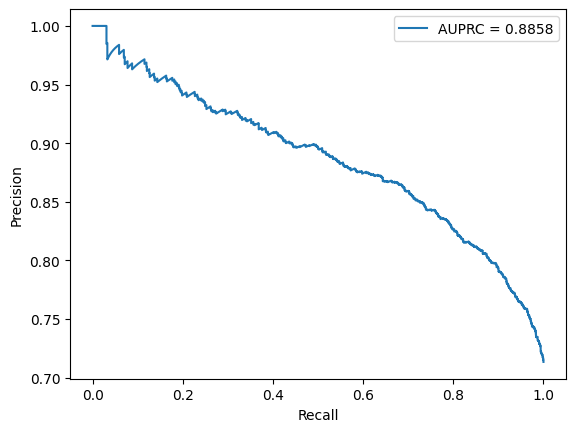

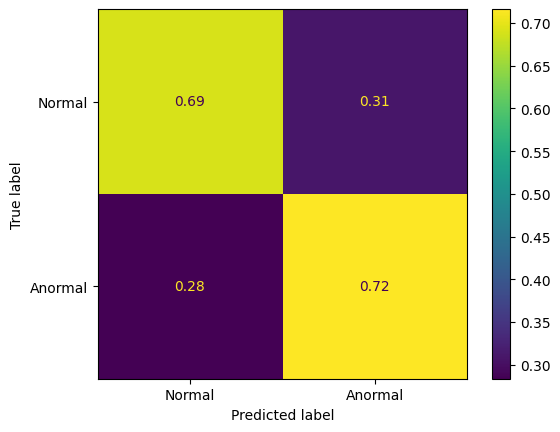

In [49]:
reconst = lstm_autoencoder.predict(X_test_features)
mae = np.mean(np.abs(X_test_features - reconst), axis=2).flatten()
precision, recall, thresholds = precision_recall_curve(y_test, mae)
auprc = auc(recall, precision)
print(f"AUPRC:{auprc:.4f}")
best_tresh = np.percentile(mae, 40)
plt.plot(recall, precision, label='AUPRC = %0.4f' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()
y_pred = (mae > best_tresh).astype(int)
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anormal'])
disp.plot()
plt.show()